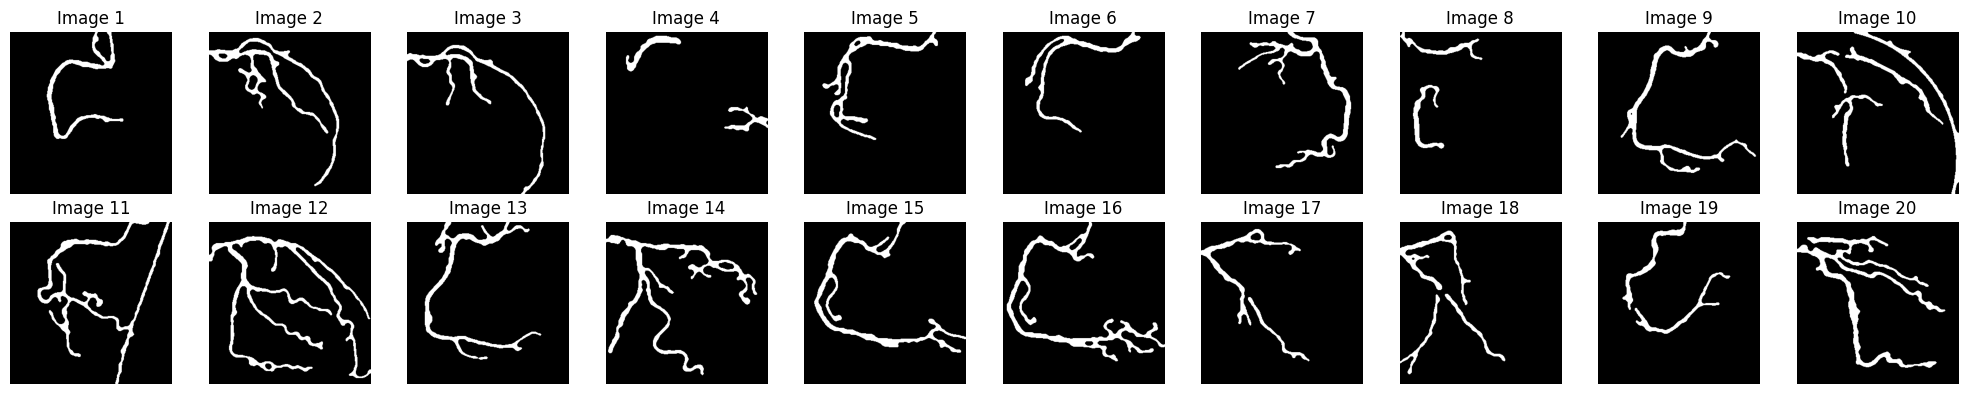

In [4]:
import cv2
import os
import matplotlib.pyplot as plt
from skimage import morphology as mo
import skimage as ski
import numpy as np

# Define el directorio donde se encuentran las imágenes
input_directory = './database'

def invert_colors(img):
    # Invertir los colores de la imagen
    return 255 - img

def filter_connected_components(binary_image_np, min_size=100, max_size=5000):
    # Encontrar componentes conectados con estadísticas.
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_image_np, connectivity=8)
    # Crear una imagen para el resultado
    filtered_img = np.zeros_like(binary_image_np)
    # Filtrar componentes basados en su tamaño.
    for i in range(1, num_labels): # Ignorar el fondo
        size = stats[i, cv2.CC_STAT_AREA]
        if min_size <= size <= max_size:
            filtered_img[labels == i] = 255
    return filtered_img


# Configura matplotlib para visualizar las imágenes en una grilla de 2 filas x 10 columnas
fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(20, 4))

# Aplanamos el array de ejes para facilitar su manejo en un bucle
axes = axes.flatten()
input_directory = './database'
output_directory = './database_binarizada'

if not os.path.exists(output_directory):
    os.makedirs(output_directory)

for i in range(1, 21):
    file_name = f'{i}.pgm'
    input_path = os.path.join(input_directory, file_name)
    
    try:
        # Lee la imagen en escala de grises
        image = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)
        
        
        kernel = mo.diamond(3)
        #opening
        opening = mo.opening(image, kernel)

        # Efectúa la ecualización del histograma
        #hist_eq_image = cv2.equalizeHist(opening, kernel)
        clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(21,21))
        clahe_image = clahe.apply(opening)

        #medians filter 
        medians = ski.filters.median(clahe_image, mo.disk(3))

        # binarización
        #_, binary = cv2.threshold(medians, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        binary = cv2.adaptiveThreshold(medians, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 13, 8)

        cleaned = mo.remove_small_objects(binary.astype(bool), min_size=64)  # Ajusta min_size según sea necesario
        cleaned = ski.img_as_ubyte(cleaned)

        cleaned = cv2.erode(cleaned, kernel, iterations=1)
        cleaned = cv2.dilate(cleaned, kernel, iterations=1)

        cleaned =ski.filters.median(cleaned, mo.disk(3)) 
        cleaned =ski.filters.median(cleaned, mo.disk(3)) 
        cleaned =ski.filters.median(cleaned, mo.disk(3)) 
        cleaned =ski.filters.median(cleaned, mo.disk(3)) 
        cleaned =ski.filters.median(cleaned, mo.disk(3)) 
        cleaned =ski.filters.median(cleaned, mo.disk(3)) 

        cleaned = cv2.dilate(cleaned, mo.disk(1), iterations=1)
        cleaned = cv2.erode(cleaned, mo.disk(1), iterations=1)

        cleaned = invert_colors(cleaned)

        cleaned = filter_connected_components(cleaned, min_size=1000, max_size=10000)

        output_path = os.path.join(output_directory, file_name)
        cv2.imwrite(output_path, cleaned)
        # Muestra la imagen en la posición correspondiente
        ax = axes[i-1]
        ax.imshow(cleaned, cmap='gray')

        ax.axis('off')
        ax.set_title(f'Image {i}')
    except FileNotFoundError:
        print(f"Archivo {input_path} no encontrado. Saltando.")

plt.tight_layout()
plt.show()


In [6]:
import numpy as np
import cv2
import os

def calculate_metrics(gt, pred):
    TP = np.sum((gt == 255) & (pred == 255))
    TN = np.sum((gt == 0) & (pred == 0))
    FP = np.sum((gt == 0) & (pred == 255))
    FN = np.sum((gt == 255) & (pred == 0))

    accuracy = (TP + TN) / (TP + TN + FP + FN)
    sensitivity = TP / (TP + FN) if (TP + FN) != 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) != 0 else 0
    precision = TP / (TP + FP) if (TP + FP) != 0 else 0
    f1_score = 2*TP / (2*TP + FP + FN) if (2*TP + FP + FN) != 0 else 0

    return accuracy, sensitivity, specificity, precision, f1_score

folder_path = './database'
miopath = './database_binarizada'

metrics = []

for i in range(1, 21):
    gt_path = os.path.join(folder_path, f'{i}_gt.pgm')
    bn_path = os.path.join(miopath, f'{i}.pgm')
    
    if os.path.exists(gt_path) and os.path.exists(bn_path):
        gt = cv2.imread(gt_path, 0)
        pred = cv2.imread(bn_path, 0)
        
        metrics.append(calculate_metrics(gt, pred))
    else:
        metrics.append((None, None, None, None, None))

print("{:<6} | {:<9} | {:<11} | {:<11} | {:<9} | {:<7}".format("Image", "Accuracy", "Sensitivity", "Specificity", "Precision", "F1 Score"))
print("-" * 70)  # Imprime una línea separadora

for i, (accuracy, sensitivity, specificity, precision, f1_score) in enumerate(metrics, 1):
    print("{:<6} | {:<9.3f} | {:<11.3f} | {:<11.3f} | {:<9.3f} | {:<7.3f}".format(i, accuracy or 0, sensitivity or 0, specificity or 0, precision or 0, f1_score or 0))


Image  | Accuracy  | Sensitivity | Specificity | Precision | F1 Score
----------------------------------------------------------------------
1      | 0.978     | 0.732       | 0.989       | 0.745     | 0.738  
2      | 0.969     | 0.889       | 0.973       | 0.618     | 0.729  
3      | 0.977     | 0.834       | 0.983       | 0.682     | 0.750  
4      | 0.959     | 0.362       | 0.987       | 0.564     | 0.441  
5      | 0.968     | 0.758       | 0.976       | 0.542     | 0.632  
6      | 0.971     | 0.667       | 0.983       | 0.595     | 0.629  
7      | 0.966     | 0.784       | 0.975       | 0.621     | 0.693  
8      | 0.970     | 0.540       | 0.991       | 0.741     | 0.625  
9      | 0.970     | 0.789       | 0.980       | 0.676     | 0.728  
10     | 0.946     | 0.795       | 0.953       | 0.437     | 0.564  
11     | 0.945     | 0.771       | 0.952       | 0.405     | 0.531  
12     | 0.951     | 0.876       | 0.958       | 0.642     | 0.741  
13     | 0.969     | 0.896     